All Season: dfc["threshold"] = 0.23 + 0.3*dfc["boy_scaled_"] - 0.16*dfc["sup_scaled_"] - 0.1*dfc["ominousness"] - 0.028*dfc["batting_team_hype"] + 0.028*dfc["pitching_team_hype"].


Buoyancy scaled is negative items, no vibes, and divided by batter multiplier.
Suppression Scaled is normal items, no vibes, and multiplied by pitcher multiplier.

The Over/Underperforming issue for the pitchers is that they don't apply. The Over/Underperforming issue for batters is that Suppression Scaled also becomes multiplied by the batter multiplier. 
Growth on the batting side also doesn't affect anything until season 16.
Traveling is only real for the pitchers, but not for batters.
Affinity for Crows is not real for batters ever

This was pushed viewing Season 12, displaying only Overperforming Batters. You will need to adjust as necessary for other circumstances as per the above.

In [31]:
import load

df = load.data("fly", season=11)

df["boy_scaled"] = load.player_attribute(
        # These values are mandatory: the dataframe, the player role, and the attribute
        df, 'batter', 'buoyancy',
        # These are all optional, and the default values are as they appear here
        vibes=False, mods=False, items="negative", broken_items=True
    )

df["sup_scaled"] = load.player_attribute(
        # These values are mandatory: the dataframe, the player role, and the attribute
        df, 'batter', 'suppression',
        # These are all optional, and the default values are as they appear here
        vibes=False, mods=False, items=True, broken_items=True
    )

    # center=True is the default
df["ominousness"] = load.stadium_attribute(df, 'ominousness', center=False)

In [32]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

pd.set_option("display.max_rows", 60)  # default 60
pd.set_option("display.max_columns", 20)  # default 20

In [33]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    #if "OVERPERFORMING" in pm:
        #mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    #if "UNDERPERFORMING" in pm:
        #mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass  # traveling just doesn't do anything on pitchers?
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "HIGH_PRESSURE" in pm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass  # growth doesn't do anything on pitchers either
    #if "SINKING_SHIP" in ptm:
        #mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    return mul


def get_batter_mul(row):
    # if row[["runner_name"]].isna().any():
    # row["runner_name"] == "NaaN"
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    attrs = ""
    if "OVERPERFORMING" in bm:
            mul += 0.2
    if "OVERPERFORMING" in btm:
            mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    #if "TRAVELING" in btm:
        #if row["top_of_inning"]:
            # is this actually 0.035 instead of 0.05?
            #mul += 0.05
    #if "TRAVELING" in bm:
        #if row["top_of_inning"]:
            # is this actually 0.035 instead of 0.05?
            #mul += 0.05
    #if "GROWTH" in btm:
        # Not Real Until Season 16
        #mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "HIGH_PRESSURE" in bm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.45
    #if "SINKING_SHIP" in btm:
        #mul += (14 - row["batting_team_roster_size"]) * 0.01
    #if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        #mul += 0.5
    #if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "power" attrs
        #mul += 1.0
        #attrs = "batter_musclitude, batter_divinity, batter_ground_friction"
    #if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "speed" attrs
        # doing 80% because of evidence from the Spin Attack blessing that "speed"
        # boosts laserlikeness 80% of what it says the total boost is?
        #mul += 0.80
        #attrs = "batter_musclitude, batter_laserlikeness, batter_ground_friction, batter_continuation"
    #if "ON_FIRE" in bm:
        # todo: handle
        # test "+125% multiplier"
       # mul += 2
        # pass
    # NVGs real??? eclipse weather, special case for Sutton Dreamy
    # surely this will not break from scattering, right? (It totally will)
    # if row["runner_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
    # NVGs allow the player to play 50% better in a solar eclipse.
    # This might affect fielding and baserunning as well?
    # mul += 0.50
    return mul, attrs


In [34]:
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)
df["batter_mul"] = df.apply(get_batter_mul, axis=1)
df[["batter_mul", "batter_mul_attrs"]] = df.apply(get_batter_mul, axis=1, result_type="expand")

In [35]:
df = df.copy()
#df = df[(df["batter_mul"] == 1)]

In [36]:
dfc = df.copy()
for exclude_mod in ["SINKING_SHIP", "LATE_TO_PARTY"]:
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in ["SINKING_SHIP", "LATE_TO_PARTY"]:
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in ["SLOW_BUILD"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]

for include_mod in ["OVERPERFORMING"]:
    dfc = dfc[dfc["batter_mods"].astype(str).str.contains(include_mod)]
for exclude_event in []:
    dfc = dfc[~dfc["event_type"].astype(str).str.contains(exclude_event)]

dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0

len(dfc)

46

In [37]:
dfc["test"] = dfc["boy_scaled"] / dfc["batter_mul"]
dfc["test2"] = dfc["sup_scaled"] * dfc["pitcher_mul"] * dfc["batter_mul"]

In [38]:
X = dfc[
    [
        "roll",
        "passed",
        "test",
        "test2",
        "ominousness",
        "batting_team_hype",
        "pitching_team_hype",
        #"pitcher_mul"

    ]
].copy()
#X = X[X["muscmul"] > 1.0]
y = X["passed"]
X = X.drop(["passed"], axis=1)

pin_intercept = 0.23
pins = [ (0.3, "test"), 
(-0.16, "test2"),
(-0.1, "ominousness"),
#(-0.07, "pitcher_mul"),
(-0.028, "batting_team_hype"),
(0.028, "pitching_team_hype")
]

for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(
    dual=False, max_iter=10000000, C=100000000, tol=1e-15, fit_intercept=pin_intercept is None
).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0, 1] + confusion_matrix(y, predictionsvm)[1, 0], "outliers")
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_   #- np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[[38  0]
 [ 0  8]]
0 outliers
1.0
0.23


[(1.0, 'roll')]

In [39]:
#0.3*dfc["boy_scaled2"] - 0.16*dfc["sup_scaled2"] 
dfc["threshold"] = 0.23 + 0.3*dfc["test"] - 0.16*dfc["test2"] - 0.1*dfc["ominousness"] - 0.028*dfc["batting_team_hype"] + 0.028*dfc["pitching_team_hype"]

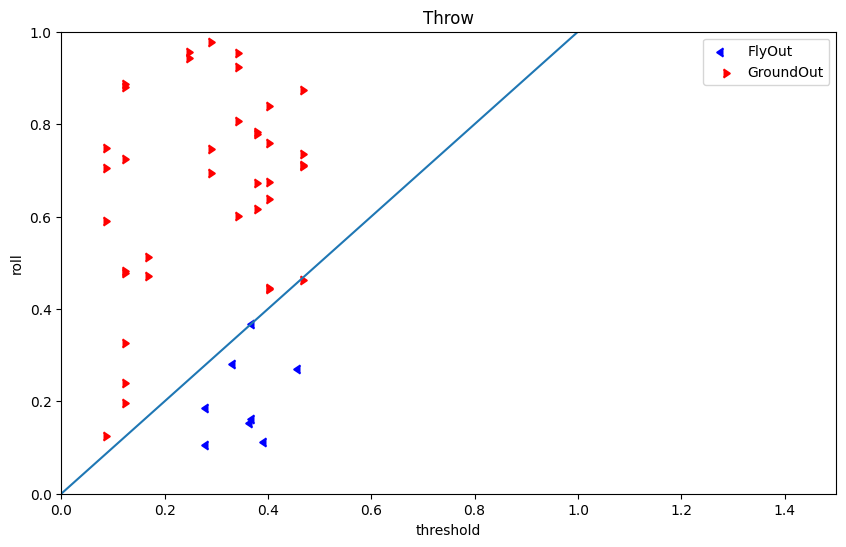

In [40]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="FlyOut", marker=CARETLEFTBASE)
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="GroundOut", marker=CARETRIGHTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Throw")
ax.set_xlim([0.0, 1.5])
ax.set_ylim([0.0, 1])
ax.legend()

,offset,event_type,roll,threshold,batter_name,pitcher_name,weather,season,batter_mods,pitcher_mods,pitching_team_mods,batter_mul,pitcher_mul,day,game_id,play_count
19833,-0.010033,GroundOut,0.204273,0.214306,Aldon Cashmoney II,Axel Cardenas,Weather.SALMON,18,SPICY;LEGENDARY;MIDDLING;REPLICA;OVERPERFORMIN...,,,1.2,1.0,49,73aaf7cd-aa85-48b0-ac57-31cc4ac55661,47
9576,-0.021930,GroundOut,0.205129,0.227059,Engine Eberhardt,Eizabeth Elliott,Weather.FLOODING,18,PRO_SKATER;OVERPERFORMING,,O_NO,1.2,1.0,27,c26d6f46-e47d-4d33-a893-e5ea884cd472,174
16276,-0.014537,GroundOut,0.339968,0.354506,Jaxon Buckley,Ziwa Mueller,Weather.SUN_2,18,FIRE_EATER;OVERPERFORMING;EGO1,SLOW_BUILD;UNCERTAIN,HIGH_PRESSURE;H20,1.2,1.0,41,c48fb383-f137-4712-81e2-85b959e63ec3,211
9972,-0.008322,GroundOut,0.251197,0.259519,Nagomi Nava,Mohammed Picklestein,Weather.SUN_2,18,HOMEBODY;FIRE_EATER;OVERPERFORMING,,PSYCHIC,1.2,1.0,28,15a21cf8-eec4-4607-acbb-001a99242fbf,111
27442,-0.018439,GroundOut,0.232383,0.250821,Nandy Fantastic,Sam Scandal,Weather.REVERB,18,MINIMALIST;OVERPERFORMING;FIRST_BORN,MINIMALIST,LIFE_OF_PARTY;AAA,1.2,1.0,77,60c6425f-10d1-4b21-85f0-cc42b8794e7c,283
25466,-0.016868,GroundOut,0.125819,0.142687,Sutton Bishop,Cravel Gesundheit,Weather.REVERB,18,REVERBERATING;TRIPLE_THREAT;PERK;INHABITING;OV...,,O_NO;HOME_FIELD,1.2,1.0,73,61184762-0033-4334-8c0f-b68ad85b5a20,252
1968,-0.018088,GroundOut,0.290058,0.308146,Velasquez Alstott,Curry Aliciakeyes,Weather.BLACK_HOLE,18,HOMEBODY;OVERPERFORMING;FIRE_EATER,OVERUNDER,O_NO,1.2,1.0,10,12e2443e-ee88-43d2-9bfb-f1edbce8d31e,27
6897,-0.004385,GroundOut,0.298721,0.303106,Velasquez Alstott,King Weatherman,Weather.PEANUTS,18,HOMEBODY;OVERPERFORMING;FIRE_EATER,SMOOTH,O_NO,1.2,1.0,20,47e6c276-06be-4c15-bf20-96adabf7d784,133
36485,-0.008873,GroundOut,0.306968,0.315840,Velasquez Alstott,Zephyr McCloud,Weather.SUN_2,18,HOMEBODY;FIRE_EATER;OVERPERFORMING;FIREPROOF,PRO_SKATER,AAA;PARTY_TIME;LIFE_OF_PARTY,1.2,1.0,98,eb93aa2a-9a1c-41b6-a9c0-104f2fe115a1,319


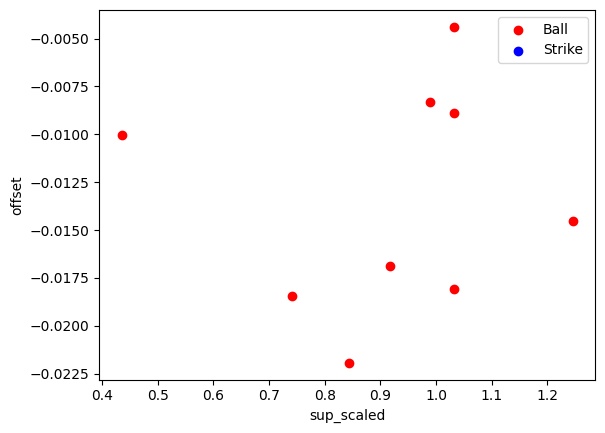

In [30]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]
#outliers = outliers[outliers["threshold"] < 0.86]


fig, ax = plt.subplots(1)
x_val = "sup_scaled"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Ball")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="Strike")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset", "event_type",
       "roll", "threshold",
       "batter_name", "pitcher_name","weather", "season", "batter_mods", "pitcher_mods", "pitching_team_mods", "batter_mul", "pitcher_mul",
       "day",  "game_id", "play_count"]].sort_values('batter_name')


In [93]:
print(dfc[dfc["passed"]]["roll"].max())
print(dfc[~dfc["passed"]]["roll"].min())

0.840592184978532
0.3265759853975572
